# Hidden Markov Models

## Caso Bolsa

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import logging
import sys

import torch
import torch.nn as nn
from torch.distributions import constraints

import numpy as np
import tensorflow as tf
#tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats as stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Leemos el excel de las bolsas

In [ ]:
data = pd.read_excel("/content/drive/MyDrive/TFG informatica/GDP.xlsx");
data["Date"] = [int(tiempo) + (tiempo-int(tiempo))*2.5 for tiempo in data["Date"]]
#data["GDP_LCHANGE"] = data["GDP"].diff()
data["Change"][0] = 0
data.head(5)

## Análisis exploratorio

Vamos a ver dos gráficos, de la evolución en los precios y la variación entre ellos:


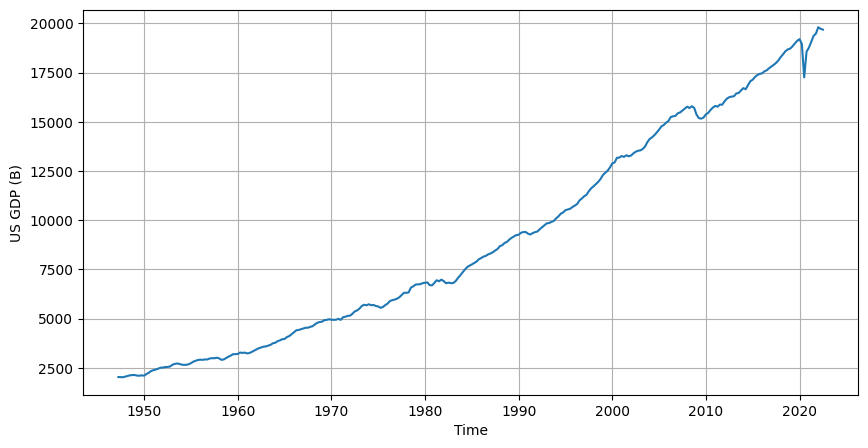

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(data["Date"], data["GDP"])
plt.xlabel("Time")
plt.ylabel("US GDP (B)")
plt.grid(True)
plt.show()

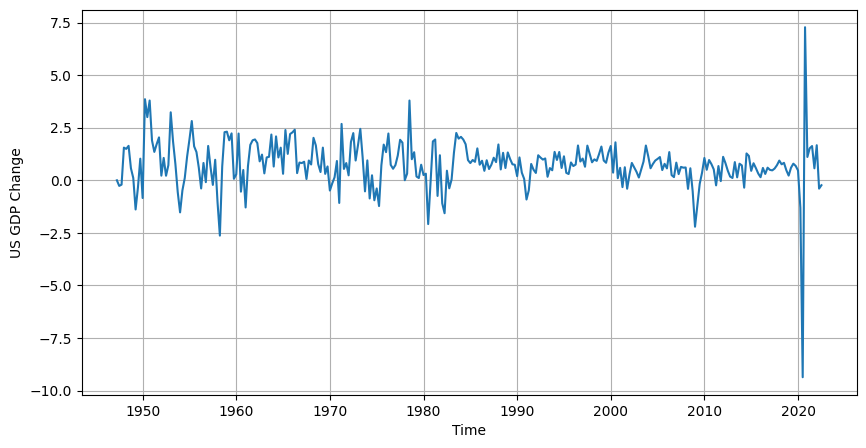

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(data["Date"], data["Change"])
plt.xlabel("Time")
plt.ylabel("US GDP Change")
plt.grid(True)
plt.show()

Hay un periodo de alta volatilidad en 2020. Como se trata de un aprendizaje supervisado, veamos qué periodos se consideran como de recesión.

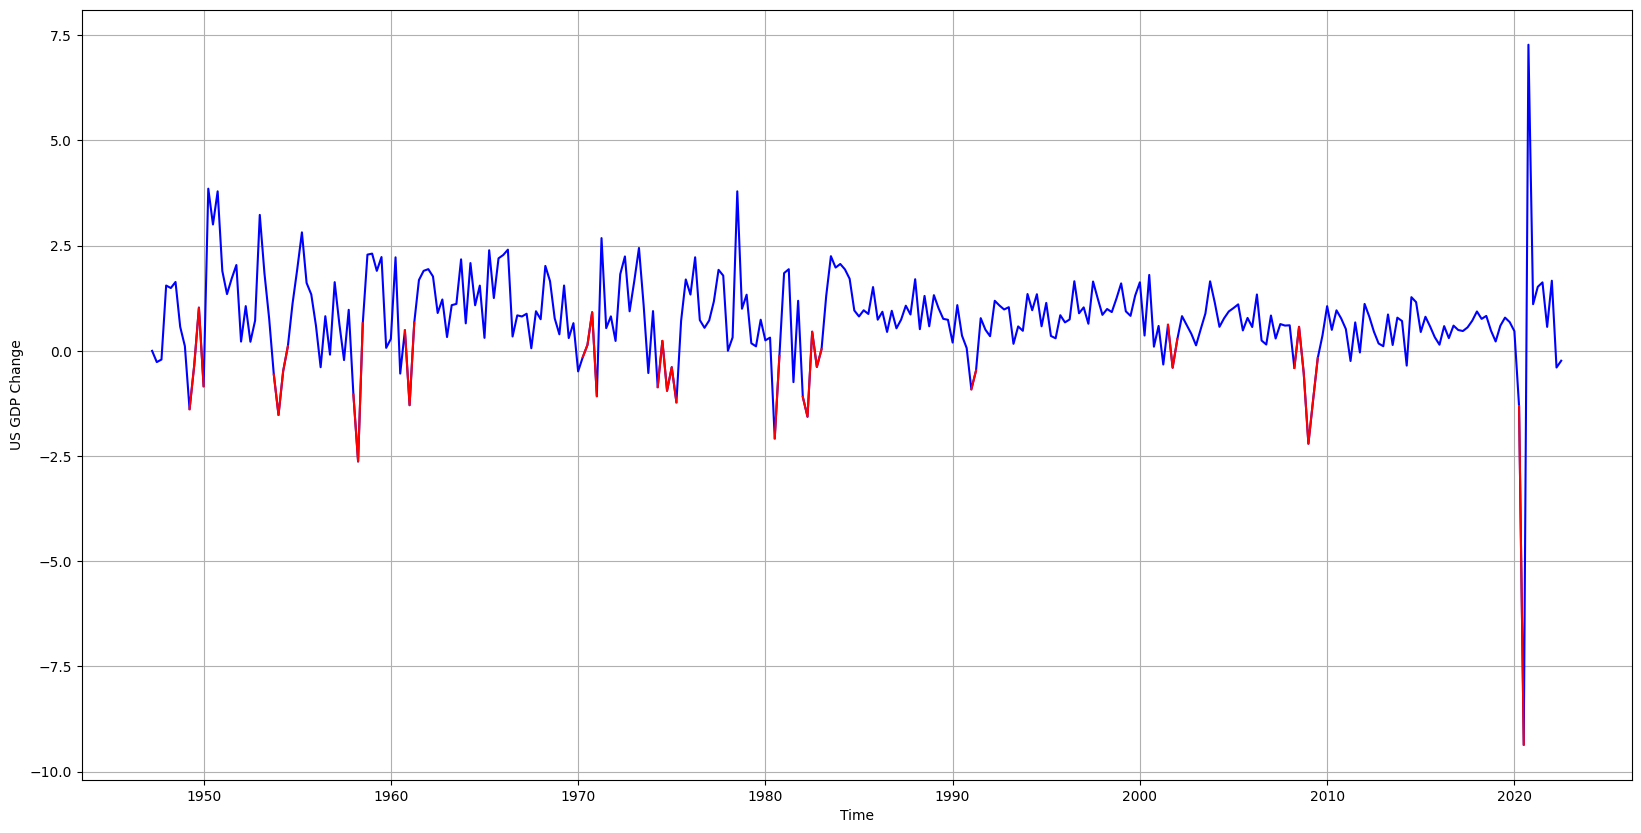

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(data["Date"], data["Change"], color="blue")
plt.plot(np.where(data["NBER"]==1, data["Date"], np.nan),
         np.where(data["NBER"]==1, data["Change"], np.nan), color="red")
plt.xlabel("Time")
plt.ylabel("US GDP Change")
plt.grid(True)
plt.show()

Vamos a ver cómo se distribuyen las variables

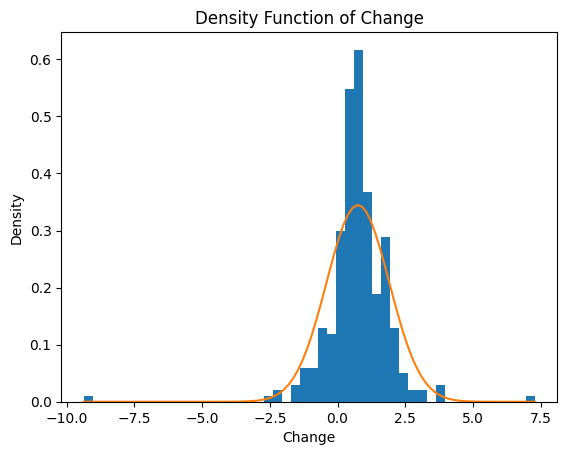

In [ ]:
# Intentamos ajustar los datos con una normal
mu, std = stats.norm.fit(data["Change"])
x = np.linspace(data["Change"].min(), data["Change"].max(), 100)
pdf = stats.norm.pdf(x, mu, std)

plt.hist(data["Change"], bins=50, density=True)
plt.plot(x, pdf)
plt.xlabel("Change")
plt.ylabel("Density")
plt.title("Density Function of Change")
plt.show()

La idea será encontrar las dos medias de las dos distribuciones normales para poder crear un modelo de mixtura que capte los dos estados con mejor precisión

In [ ]:
data["Change"].loc[data["NBER"]==0]

0      0.000000
1     -0.267062
2     -0.206717
3      1.552168
4      1.492999
         ...   
297    1.627432
298    0.569324
299    1.666809
300   -0.396477
301   -0.234643
Name: Change, Length: 259, dtype: float64

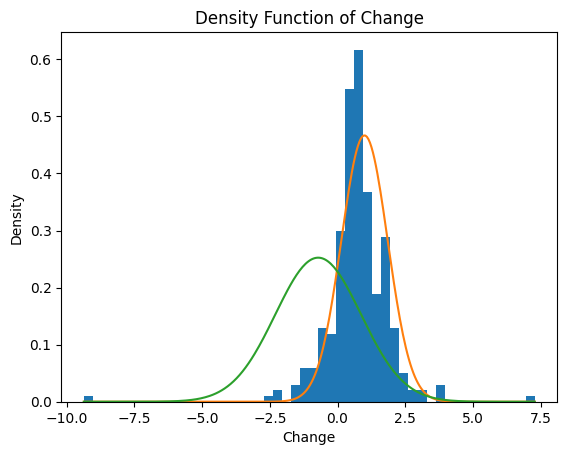

In [ ]:
# Intentamos ajustar los datos con una normal
mu, std = stats.norm.fit(data["Change"].loc[data["NBER"]==0])
mu2, std2 = stats.norm.fit(data["Change"].loc[data["NBER"]==1])
x = np.linspace(data["Change"].min(), data["Change"].max(), len(data["Change"]))
pdf = stats.norm.pdf(x, mu, std)
pdf2 = stats.norm.pdf(x, mu2, std2)

plt.hist(data["Change"], bins=50, density=True)
plt.plot(x, pdf)
plt.plot(x, pdf2)
plt.xlabel("Change")
plt.ylabel("Density")
plt.title("Density Function of Change")
plt.show()

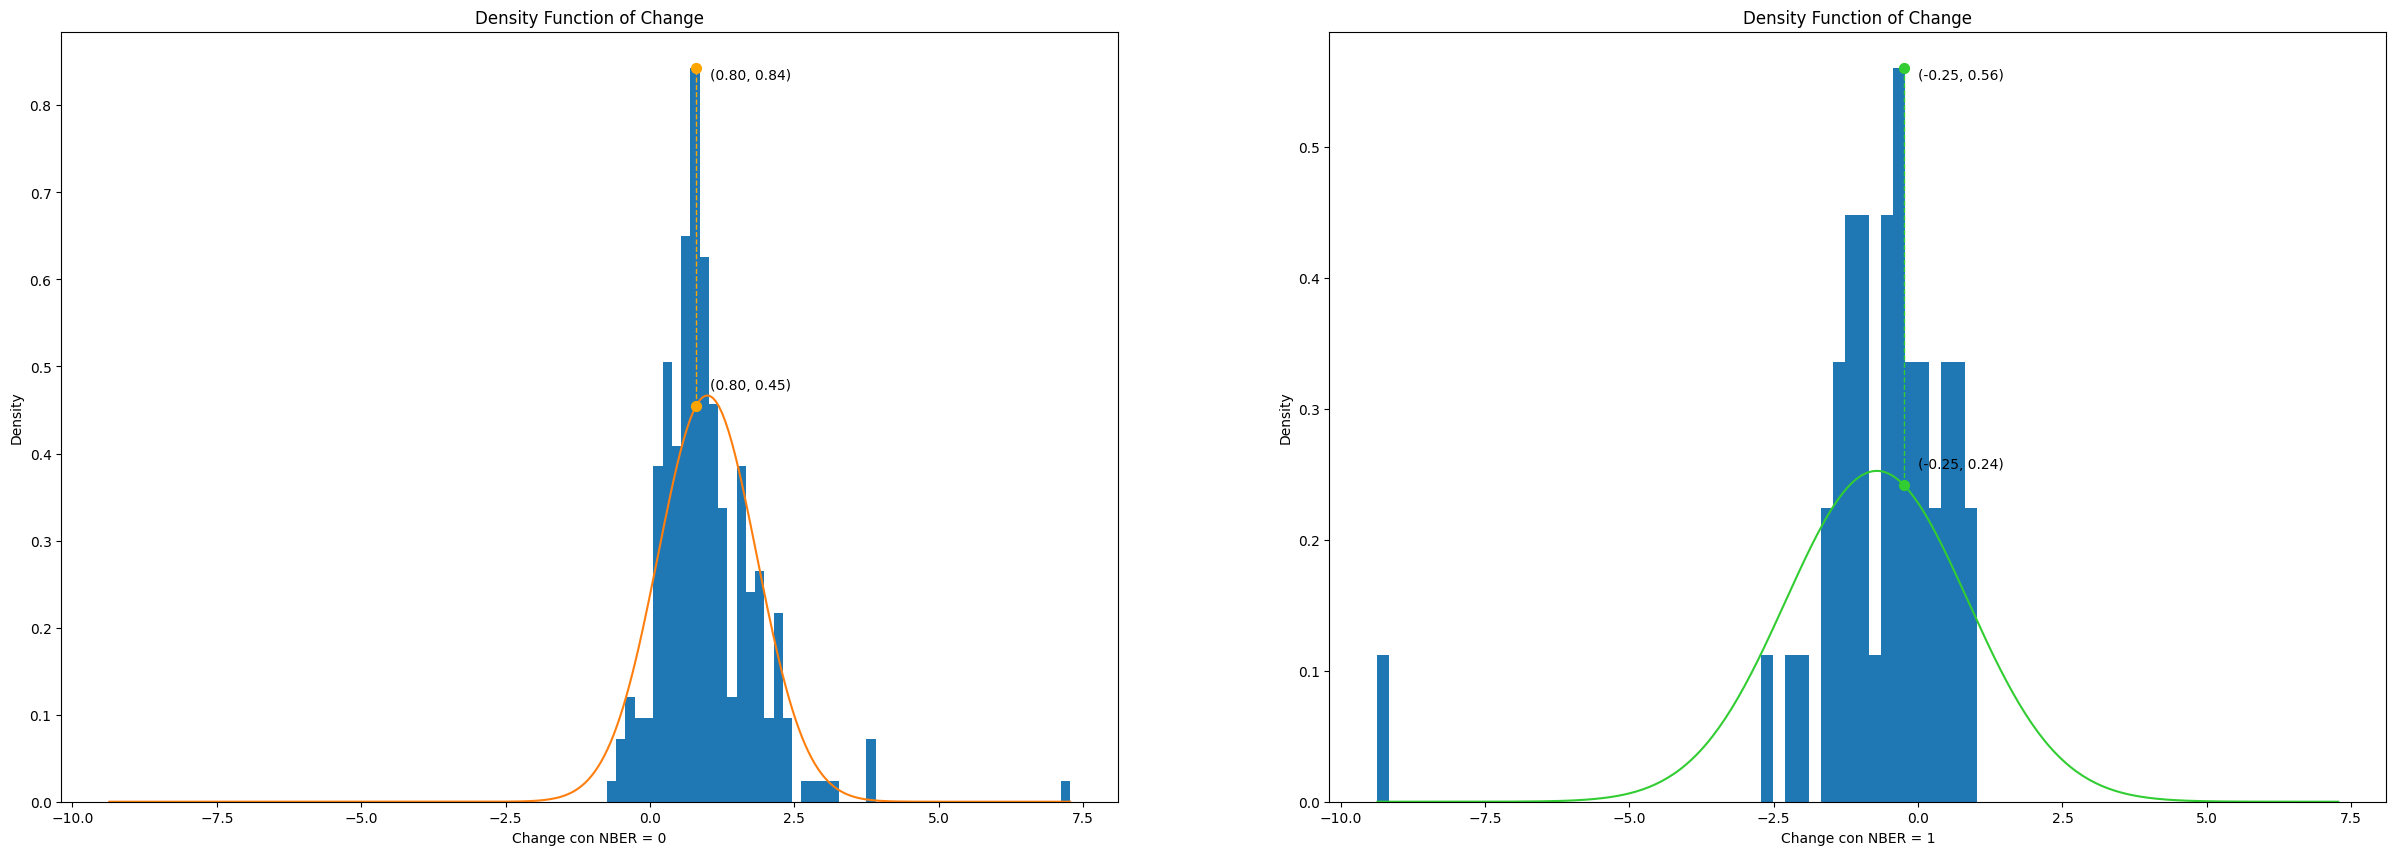

In [ ]:
# Intentamos ajustar los datos con una normal
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 10))
plt.subplot(1,2,1)
datos = data["Change"].loc[data["NBER"]==0]
mu, std = stats.norm.fit(datos)
x = np.linspace(data["Change"].min(), data["Change"].max(), len(data["Change"]))
pdf = stats.norm.pdf(x, mu, std)

plt.hist(datos, bins=50, density=True)
plt.plot(x, pdf)
plt.xlabel("Change con NBER = 0")
plt.ylabel("Density")
plt.title("Density Function of Change")
x_point = 0.8
pdf_point = stats.norm.pdf(x_point, mu, std)
hist, bin_edges = np.histogram(datos, bins=50, density=True)
hist_point = hist[np.searchsorted(bin_edges, x_point, side='right')-1]
# Dibuja un punto rojo en el punto deseado en la función de densidad
plt.scatter(x_point, pdf_point, color='orange', s=50, zorder=3)
plt.annotate(f'({x_point:.2f}, {pdf_point:.2f})', (x_point, pdf_point), xytext=(10, 10), textcoords='offset points', ha='left', va='bottom')
# Dibuja un punto rojo en el punto deseado en el histograma
plt.scatter(x_point, hist_point, color='orange', s=50, zorder=3)
plt.annotate(f'({x_point:.2f}, {hist_point:.2f})', (x_point, hist_point), xytext=(10, 0), textcoords='offset points', ha='left', va='top')
plt.plot([x_point, x_point], [pdf_point, hist_point], color='orange', linestyle='--', linewidth=1)

plt.subplot(1,2,2)
datos2 = data["Change"].loc[data["NBER"]==1]
mu2, std2 = stats.norm.fit(datos2)
x2 = np.linspace(data["Change"].min(), data["Change"].max(), len(data["Change"]))
pdf2 = stats.norm.pdf(x2, mu2, std2)

plt.hist(datos2, bins=50, density=True)
plt.plot(x2, pdf2, color="limegreen")
plt.xlabel("Change con NBER = 1")
plt.ylabel("Density")
plt.title("Density Function of Change")
x_point2 = -0.25
pdf_point2 = stats.norm.pdf(x_point2, mu2, std2)
hist2, bin_edges2 = np.histogram(datos2, bins=50, density=True)
hist_point2 = hist2[np.searchsorted(bin_edges2, x_point2, side='right')-1]
# Dibuja un punto rojo en el punto deseado en la función de densidad
plt.scatter(x_point2, pdf_point2, color='limegreen', s=50, zorder=3)
plt.annotate(f'({x_point2:.2f}, {pdf_point2:.2f})', (x_point2, pdf_point2), xytext=(10, 10), textcoords='offset points', ha='left', va='bottom')
# Dibuja un punto rojo en el punto deseado en el histograma
plt.scatter(x_point2, hist_point2, color='limegreen', s=50, zorder=3)
plt.annotate(f'({x_point2:.2f}, {hist_point2:.2f})', (x_point2, hist_point2), xytext=(10, 0), textcoords='offset points', ha='left', va='top')
plt.plot([x_point2, x_point2], [pdf_point2, hist_point2], color='limegreen', linestyle='--', linewidth=1)

plt.show()

In [ ]:
from scipy.stats import kstest

mu, std = stats.norm.fit(data["Change"].loc[data["NBER"]==0])
print("KSTest (NBER = 0):", kstest(data["Change"].loc[data["NBER"]==0], stats.norm.cdf(x, mu, std)))
mu, std = stats.norm.fit(data["Change"].loc[data["NBER"]==1])
print("KSTest (NBER = 1):", kstest(data["Change"].loc[data["NBER"]==1], stats.norm.cdf(x, mu, std)))


KSTest (NBER = 0): KstestResult(statistic=0.4790713135083996, pvalue=1.6290603683426422e-29, statistic_location=0.09388324015880606, statistic_sign=-1)
KSTest (NBER = 1): KstestResult(statistic=0.6976744186046512, pvalue=1.7945884348739528e-18, statistic_location=-0.11891779649300105, statistic_sign=1)


## Modelo Oculto de Markov


In [ ]:
train = data
test = data

### Caso Naive (mismo conjunto de datos para entrenamiento y prueba)

En primer lugar hay una versión guiada de un primer acercamiento usando los mismos datos de entrenamiento y de test, posteriormente encapsularemos en funciones la creación y optimización del HMM y usaremos un sistema de validación cruzada progresiva.

El primer caso intenta usar la variable `data["NBER"]` para estimar los parámetros $\lambda = \{A, B, \pi\}$ del modelo oculto de Markov.

In [ ]:
nber_1 = (train["NBER"] == 1).sum()
nber_0 = (train["NBER"] == 0).sum()

# P(nber = 1 | 0)  y P(nber = 0| 1)
cond_0 = ((train['NBER'] == 1) & (train['NBER'].shift() == 0)).sum()
cond_1 = ((train['NBER'] == 0) & (train['NBER'].shift() == 1)).sum()

#Llamemos Pij a la probabilidad de ir del estado i al j, entonces la matriz de transición es:
p01 = cond_0/nber_0
p00 = 1 - p01
p10 = cond_1/nber_1
p11 = 1 - p10

In [ ]:
#Tenemos 2 estados, recesión o no recesión
num_states = 2
batch_size = 1

#Vamos a iniciar con las proporciones de transición acorde a los datos
proporcion_rec = (train["NBER"] == 1).sum() /len(train["NBER"])

# Inicializamos las probabilidades iniciales 
initial_state_probs = tf.Variable([1 - proporcion_rec, proporcion_rec], dtype=tf.float32)
# Suma 1
initial_state_probs = initial_state_probs / tf.reduce_sum(initial_state_probs)

# Creamos la matriz de transición
transition_probs = tf.Variable([[p00,p01],[p10,p11]], dtype=tf.float32)
# Suma 1
transition_probs = transition_probs / tf.reduce_sum(transition_probs, axis=1, keepdims=True)


# Inicializamos las probabilidades de emisión
# Supongamos que los cambios se modelan como una distribución Normal
media_recesion = train.loc[train["NBER"] == 1, "Change"].mean()
media_no_recesion = train.loc[train["NBER"] == 0, "Change"].mean()
std_recesion = train.loc[train["NBER"] == 1, "Change"].std(ddof=0)
std_no_recesion = train.loc[train["NBER"] == 0, "Change"].std(ddof=0)

starting_loc =  tf.Variable([media_no_recesion, media_recesion], shape = (2,), dtype=tf.float32, name = "medias")
starting_scale = tf.Variable([ std_no_recesion, std_recesion], shape = (2,), dtype=tf.float32, name = "varianzas")
observation_distribution = tfd.Normal(loc= starting_loc, scale=starting_scale)

In [ ]:
print(initial_state_probs)
print(transition_probs)
print(starting_loc)
print(starting_scale)

tf.Tensor([0.8576159  0.14238411], shape=(2,), dtype=float32)
tf.Tensor(
[[0.95366794 0.04633205]
 [0.27906978 0.7209302 ]], shape=(2, 2), dtype=float32)
<tf.Variable 'medias:0' shape=(2,) dtype=float32, numpy=array([ 0.99490494, -0.7147465 ], dtype=float32)>
<tf.Variable 'varianzas:0' shape=(2,) dtype=float32, numpy=array([0.8546541, 1.5801374], dtype=float32)>


In [ ]:
# Create the HiddenMarkovModel object
hmm = tfp.distributions.HiddenMarkovModel(
    initial_distribution=tfd.Categorical(probs=initial_state_probs),
    transition_distribution=tfd.Categorical(probs=transition_probs),
    observation_distribution=observation_distribution,
    num_steps=len(train),
    validate_args=True
)


Ahora podemos realizar predicciones con este modelo, empecemos por predecir todos los datos con los que hemos generado el modelo:

In [ ]:
posterior_dists = hmm.posterior_marginals(test["Change"].astype(np.float32))
posterior_probs = posterior_dists.probs_parameter().numpy()
predicted_results  = hmm.posterior_mode(test["Change"].astype(np.float32)).numpy() 
print(predicted_results)
print(np.array(test["NBER"]))
most_probable_rates = tf.gather(starting_loc, predicted_results )

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 

Veámos visualmente el error que hemos cometido:

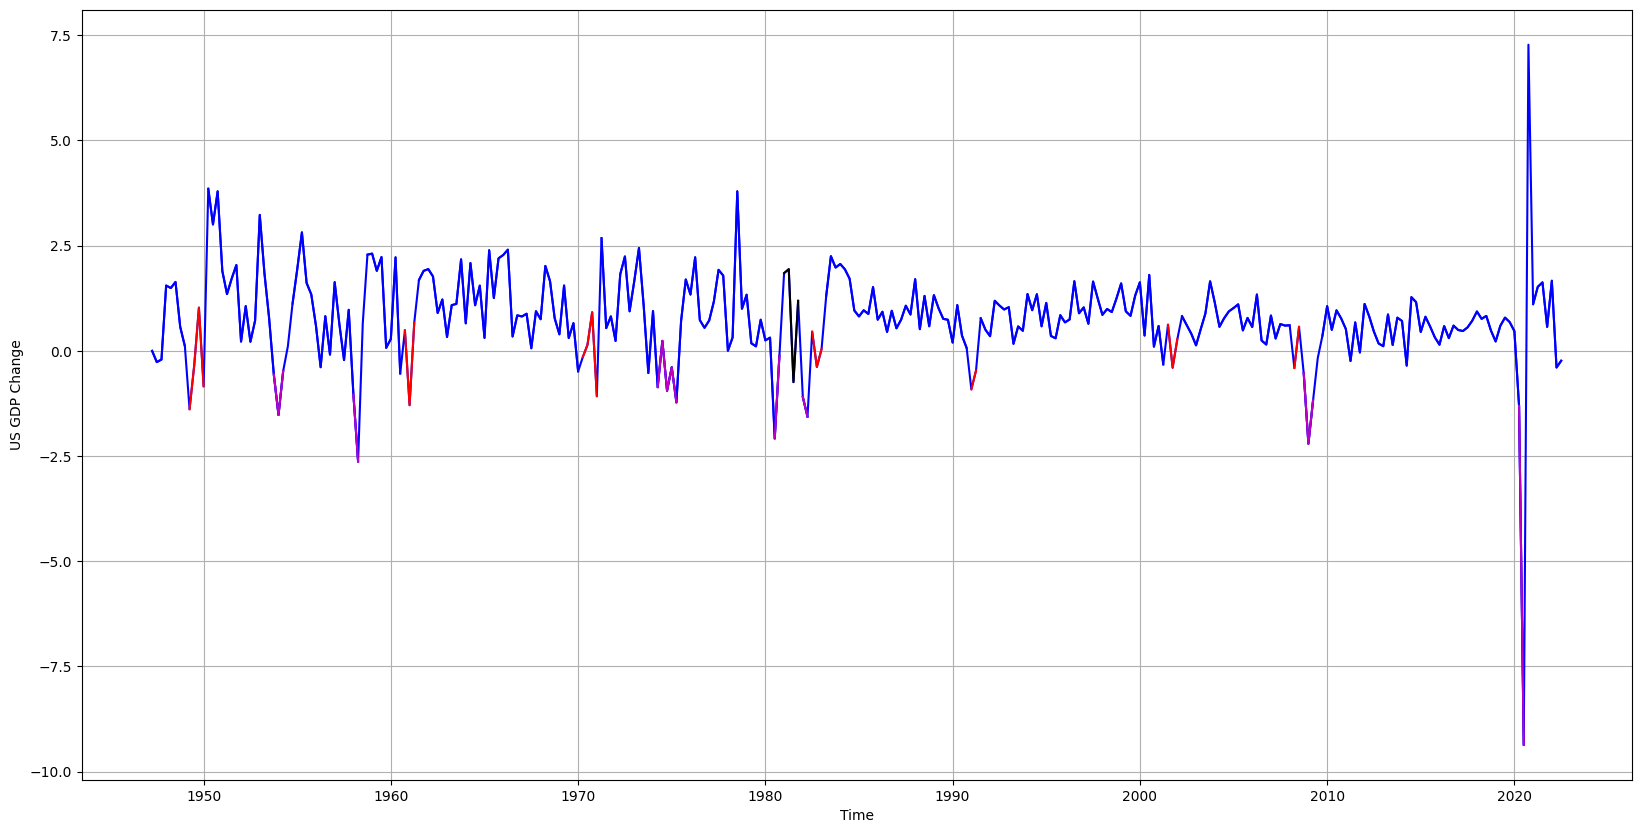

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(test["Date"], test["Change"], color="blue")
plt.plot(np.where(np.equal(predicted_results , test["NBER"]), test["Date"], np.nan),
         np.where(np.equal(predicted_results , test["NBER"]), test["Change"], np.nan), color="blue")
plt.plot(np.where((predicted_results==0) & (test["NBER"]==1), test["Date"], np.nan),
         np.where((predicted_results==0) & (test["NBER"]==1), test["Change"], np.nan), color="red")
plt.plot(np.where((predicted_results==1) & (test["NBER"]==0), test["Date"], np.nan),
         np.where((predicted_results==1) & (test["NBER"]==0), test["Change"], np.nan), color="k")
plt.plot(np.where((predicted_results==1) & (test["NBER"]==1), test["Date"], np.nan),
         np.where((predicted_results==1) & (test["NBER"]==1), test["Change"], np.nan), color="m")
plt.xlabel("Time")
plt.ylabel("US GDP Change")
plt.grid(True)
plt.show()

Ahora vamos a evaluar el modelo respecto a los datos.

In [ ]:
def compute_Fbeta_score(true_values, predicted_results, beta = 1):
  true_values = test["NBER"]

  # Calculate number of true positives, false positives, true negatives, and false negatives
  true_positives = np.sum(np.logical_and(predicted_results == 1, true_values == 1))
  false_positives = np.sum(np.logical_and(predicted_results == 1, true_values == 0))
  true_negatives = np.sum(np.logical_and(predicted_results == 0, true_values == 0))
  false_negatives = np.sum(np.logical_and(predicted_results == 0, true_values == 1))

  # Calculate accuracy, false positive rate, and false negative rate
  accuracy = (true_positives + true_negatives) / len(true_values)
  false_positive_rate = false_positives / (false_positives + true_negatives)
  false_negative_rate = false_negatives / (false_negatives + true_positives)

  # Calculate precision and recall
  precision = true_positives / (true_positives + false_positives)
  recall = true_positives / (true_positives + false_negatives)

  # Calculate Fbeta score
  if precision + recall > 0:
      fbeta_score = (1+beta**2) * (precision * recall) / ((beta**2) * precision + recall)
  else:
      fbeta_score = 0

  return fbeta_score

In [ ]:
print("F1-score:",compute_Fbeta_score(test["NBER"],predicted_results))
print("F2-score:",compute_Fbeta_score(test["NBER"],predicted_results,beta=2))

F1-score: 0.5671641791044777
F2-score: 0.48469387755102045


Existe una serie de variables del HMM que pueden ser entrenadas:

In [ ]:
hmm.trainable_variables

(<tf.Variable 'medias:0' shape=(2,) dtype=float32, numpy=array([ 0.99490494, -0.7147465 ], dtype=float32)>,
 <tf.Variable 'varianzas:0' shape=(2,) dtype=float32, numpy=array([0.8546541, 1.5801374], dtype=float32)>)

#### Optimización con log-verosimilitud

Vamos a entrenar ahora el HMM usando un optimizador Adam y veamos el resultado:

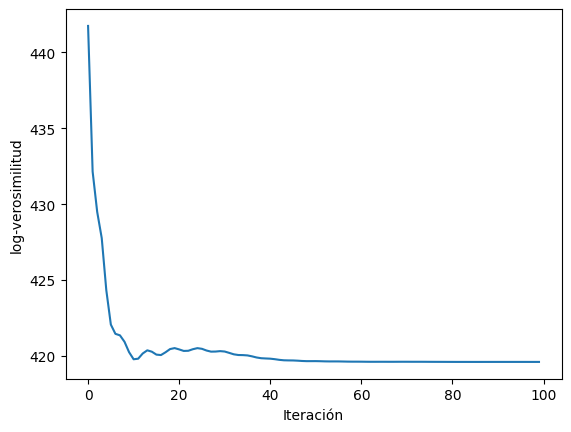

In [ ]:
# Distribuciones a priori no informativas
prior_loc = tfd.Normal(loc=0., scale=5.)
prior_scale = tfd.HalfNormal(scale=5.)
#https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations

def negative_log_likelihood():
  log_prob = hmm.log_prob(train["Change"])
  log_prob += tf.reduce_sum(prior_loc.log_prob(observation_distribution.loc))
  log_prob += tf.reduce_sum(prior_scale.log_prob(observation_distribution.scale))
  return -log_prob


losses = tfp.math.minimize(
    lambda: negative_log_likelihood(),
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=100)

plt.plot(losses)
plt.xlabel("Iteración")
plt.ylabel("log-verosimilitud")
plt.show()

In [ ]:
hmm.trainable_variables

(<tf.Variable 'medias:0' shape=(2,) dtype=float32, numpy=array([0.8259794 , 0.36189362], dtype=float32)>,
 <tf.Variable 'varianzas:0' shape=(2,) dtype=float32, numpy=array([0.6894928, 2.3618324], dtype=float32)>)

In [ ]:
predicted_results  = hmm.posterior_mode(test["Change"].astype(np.float32)).numpy() 
print("F1-score:",compute_Fbeta_score(test["NBER"],predicted_results))
print("F2-score:",compute_Fbeta_score(test["NBER"],predicted_results,beta=2))

F1-score: 0.5897435897435898
F2-score: 0.5555555555555556


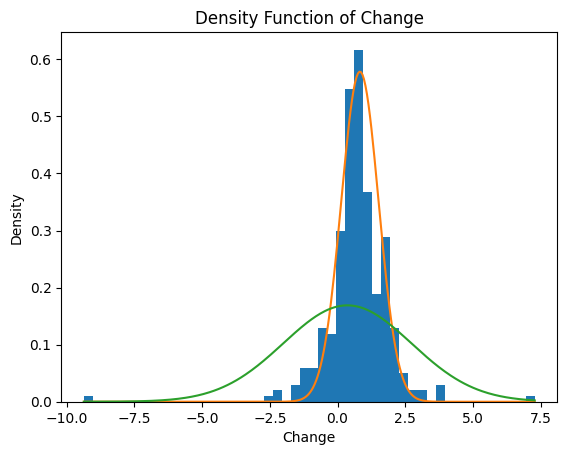

In [ ]:
# Gráfico del modelo de mixtura con las dos nuevas distribuciones
mu, std = hmm.trainable_variables[0][0].numpy(), hmm.trainable_variables[1][0].numpy()
mu2, std2 = hmm.trainable_variables[0][1].numpy(), hmm.trainable_variables[1][1].numpy()
x = np.linspace(data["Change"].min(), data["Change"].max(), len(data["Change"]))
pdf = stats.norm.pdf(x, mu, std)
pdf2 = stats.norm.pdf(x, mu2, std2)

plt.hist(data["Change"], bins=50, density=True)
plt.plot(x, pdf)
plt.plot(x, pdf2)
plt.xlabel("Change")
plt.ylabel("Density")
plt.title("Density Function of Change")
plt.show()

#### Optimización con binary cross-entropy

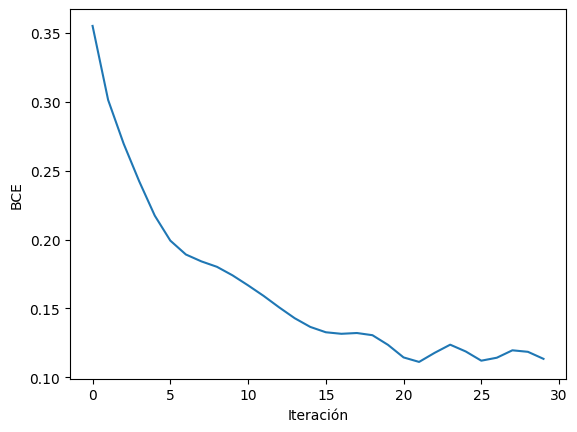

In [ ]:

"""
BCE = 0
for y, prob in zip(test["NBER"],posterior_probs):
  BCE +=y*np.log(prob[1])+(1-y)*np.log((1-prob[1]))
BCE = -BCE / len(posterior_probs)
"""
def compute_bce():
  posterior_dists = hmm.posterior_marginals(test["Change"].astype(np.float32))
  posterior_probs = posterior_dists.probs_parameter()
  bce = tf.losses.BinaryCrossentropy()
  return bce(test["NBER"],posterior_probs[:,1])


losses = tfp.math.minimize(
    lambda: compute_bce(),
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=30)
plt.plot(losses)
plt.xlabel("Iteración")
plt.ylabel("BCE")
plt.show()

In [ ]:
hmm.trainable_variables

(<tf.Variable 'medias:0' shape=(2,) dtype=float32, numpy=array([ 1.8265241, -1.5253124], dtype=float32)>,
 <tf.Variable 'varianzas:0' shape=(2,) dtype=float32, numpy=array([0.9013158, 0.9727717], dtype=float32)>)

In [ ]:
predicted_results  = hmm.posterior_mode(test["Change"].astype(np.float32)).numpy() 
print("F1-score:",compute_Fbeta_score(test["NBER"],predicted_results))
print("F2-score:",compute_Fbeta_score(test["NBER"],predicted_results,beta=2))

F1-score: 0.8444444444444444
F2-score: 0.8675799086757989


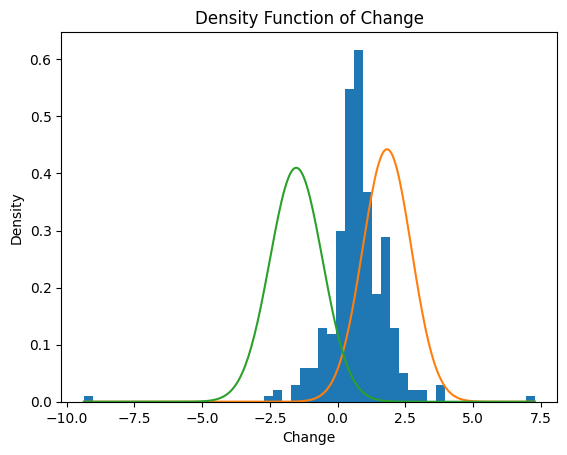

In [ ]:
# Gráfico del modelo de mixtura con las dos nuevas distribuciones
mu, std = hmm.trainable_variables[0][0].numpy(), hmm.trainable_variables[1][0].numpy()
mu2, std2 = hmm.trainable_variables[0][1].numpy(), hmm.trainable_variables[1][1].numpy()
x = np.linspace(data["Change"].min(), data["Change"].max(), len(data["Change"]))
pdf = stats.norm.pdf(x, mu, std)
pdf2 = stats.norm.pdf(x, mu2, std2)

plt.hist(data["Change"], bins=50, density=True)
plt.plot(x, pdf)
plt.plot(x, pdf2)
plt.xlabel("Change")
plt.ylabel("Density")
plt.title("Density Function of Change")
plt.show()

### Caso Naive

Ahora vamos a dividir el conjunto de datos principal en dos subconjuntos, uno para entrenamiento y otro para pruebas. Antes de hacer la división es necesario encapsular el procedimiento anterior en funciones:

In [ ]:
def naive_HMM_setup(train, y_train):
  nber_1 = (y_train == 1).sum()
  nber_0 = (y_train == 0).sum()

  # P(nber = 1 | 0)  y P(nber = 0| 1)
  cond_0 = ((y_train == 1) & (np.roll(y_train, -1) == 0)).sum()
  cond_1 = ((y_train == 0) & (np.roll(y_train, -1) == 1)).sum()

  #Llamemos Pij a la probabilidad de ir del estado i al j, entonces la matriz de transición es:
  p01 = cond_0/nber_0
  p00 = 1 - p01
  p10 = cond_1/nber_1
  p11 = 1 - p10

  #Tenemos 2 estados, recesión o no recesión
  num_states = 2
  batch_size = 1

  #Vamos a iniciar con las proporciones de transición acorde a los datos
  proporcion_rec = (y_train == 1).sum() /len(y_train)

  # Inicializamos las probabilidades iniciales 
  initial_state_probs = tf.Variable([1 - proporcion_rec, proporcion_rec], dtype=tf.float32)
  # Suma 1
  initial_state_probs = initial_state_probs / tf.reduce_sum(initial_state_probs)

  # Creamos la matriz de transición
  transition_probs = tf.Variable([[p00,p01],[p10,p11]], dtype=tf.float32)
  # Suma 1
  transition_probs = transition_probs / tf.reduce_sum(transition_probs, axis=1, keepdims=True)


  # Inicializamos las probabilidades de emisión
  # Supongamos que los cambios se modelan como una distribución Normal
  media_recesion = np.mean(train[:,1][y_train == 1])
  media_no_recesion = np.mean(train[:,1][y_train == 0])
  std_recesion = np.std(train[:,1][y_train == 1])
  std_no_recesion = np.std(train[:,1][y_train == 0])

  starting_loc =  tf.Variable([media_no_recesion, media_recesion], shape = (2,), dtype=tf.float32, name = "medias")
  starting_scale = tf.Variable([ std_no_recesion, std_recesion], shape = (2,), dtype=tf.float32, name = "varianzas")
  observation_distribution = tfd.Normal(loc= starting_loc, scale=starting_scale)
  print(initial_state_probs)
  print(transition_probs)
  print(starting_loc)
  print(starting_scale)

  # HiddenMarkovModel
  hmm = tfp.distributions.HiddenMarkovModel(
      initial_distribution=tfd.Categorical(probs=initial_state_probs),
      transition_distribution=tfd.Categorical(probs=transition_probs),
      observation_distribution=observation_distribution,
      num_steps=len(train),
      validate_args=True
  )
  return hmm


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
X = data[["Date","Change"]].to_numpy()
y = data["NBER"].to_numpy()
for i, (train_index, test_index) in enumerate(tscv.split(X,y)):
  #print('TRAIN:', train_index, 'TEST:', test_index)
  train, test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  # Obtenemos el hmm
  hmm = naive_HMM_setup(train,y_train)
  #calculamos para este primer HMM las F-scores
  predicted_results  = hmm.posterior_mode(test[:,1].astype(np.float32)).numpy() 
  print("F1-score (i):",compute_Fbeta_score(y_test,predicted_results))
  print("F2-score (i):",compute_Fbeta_score(y_test,predicted_results,beta=2))


### Caso Baum-Welch

Para comenzar vamos a iniciar el algoritmo partiendo desde los parámetros que usamos en el enfoque anterior, no obstante, como hemos visto en la teoría hay varias advertencias a las que tenemos que prestar atención. Por ejemplo, recordemos que la función de verosimilitud tiene varios máximos locales y por ello ejecutaremos el algoritmo con varias condiciones iniciales.

In [ ]:
def create_HMM(initial_state_matrix,transition_matrix,distributions):
    initial_state_probs = tf.Variable(initial_state_matrix, dtype=tf.float32)
    # Suma 1
    initial_state_probs = initial_state_probs / tf.reduce_sum(initial_state_probs)

    # Creamos la matriz de transición
    transition_probs = tf.Variable(transition_matrix, dtype=tf.float32)
    # Suma 1
    transition_probs = transition_probs / tf.reduce_sum(transition_probs, axis=1, keepdims=True)

    # Inicializamos las probabilidades de emisión
    # Supongamos que los cambios se modelan como una distribución Normal
    media_recesion = train.loc[train["NBER"] == 1, "Change"].mean()
    media_no_recesion = train.loc[train["NBER"] == 0, "Change"].mean()
    std_recesion = train.loc[train["NBER"] == 1, "Change"].std(ddof=0)
    std_no_recesion = train.loc[train["NBER"] == 0, "Change"].std(ddof=0)

    starting_loc = tf.Variable([distribution.loc for distribution in distributions], shape=(2,), dtype=tf.float32,
                               name="medias")
    starting_scale = tf.Variable([distribution.scale for distribution in distributions], shape=(2,), dtype=tf.float32,
                                 name="varianzas")
    observation_distribution = tfd.Normal(loc=starting_loc, scale=starting_scale)
    # HiddenMarkovModel
    hmm = tfp.distributions.HiddenMarkovModel(
        initial_distribution=tfd.Categorical(probs=initial_state_probs),
        transition_distribution=tfd.Categorical(probs=transition_probs),
        observation_distribution=observation_distribution,
        num_steps=len(train),
        validate_args=True
    )
    return hmm

In [ ]:
nber_1 = (train["NBER"] == 1).sum()
nber_0 = (train["NBER"] == 0).sum()

# P(nber = 1 | 0)  y P(nber = 0| 1)
cond_0 = ((train['NBER'] == 1) & (train['NBER'].shift() == 0)).sum()
cond_1 = ((train['NBER'] == 0) & (train['NBER'].shift() == 1)).sum()

#Llamemos Pij a la probabilidad de ir del estado i al j, entonces la matriz de transición es:
p01 = cond_0/nber_0
p00 = 1 - p01
p10 = cond_1/nber_1
p11 = 1 - p10
#Tenemos 2 estados, recesión o no recesión
num_states = 2
batch_size = 1

#Vamos a iniciar con las proporciones de transición acorde a los datos
proporcion_rec = (train["NBER"] == 1).sum() /len(train["NBER"])

# Inicializamos las probabilidades iniciales 
initial_state_matrix = np.array([1 - proporcion_rec, proporcion_rec])
initial_state_probs = tf.Variable(initial_state_matrix, dtype=tf.float32)
# Suma 1
initial_state_probs = initial_state_probs / tf.reduce_sum(initial_state_probs)

# Creamos la matriz de transición
transition_matrix = np.array([[p00,p01],[p10,p11]])
transition_probs = tf.Variable(transition_matrix, dtype=tf.float32)
# Suma 1
transition_probs = transition_probs / tf.reduce_sum(transition_probs, axis=1, keepdims=True)


# Inicializamos las probabilidades de emisión
# Supongamos que los cambios se modelan como una distribución Normal
media_recesion = train.loc[train["NBER"] == 1, "Change"].mean()
media_no_recesion = train.loc[train["NBER"] == 0, "Change"].mean()
std_recesion = train.loc[train["NBER"] == 1, "Change"].std(ddof=0)
std_no_recesion = train.loc[train["NBER"] == 0, "Change"].std(ddof=0)

prior_1= tfd.Normal(loc=media_no_recesion, scale=std_no_recesion)
prior_2= tfd.Normal(loc=media_recesion, scale=std_recesion)

starting_loc =  tf.Variable([media_no_recesion, media_recesion], shape = (2,), dtype=tf.float32, name = "medias")
starting_scale = tf.Variable([ std_no_recesion, std_recesion], shape = (2,), dtype=tf.float32, name = "varianzas")
observation_distribution = tfd.Normal(loc= starting_loc, scale=starting_scale)
#HiddenMarkovModel
hmm = tfp.distributions.HiddenMarkovModel(
    initial_distribution=tfd.Categorical(probs=initial_state_probs),
    transition_distribution=tfd.Categorical(probs=transition_probs),
    observation_distribution=observation_distribution,
    num_steps=len(train),
    validate_args=True
)

Ahora vamos a calcular las probabilidades forward y backward:

In [ ]:
def emission_probs(distributions,observations):
  e = [[distributions[i].prob(observations[t]) for t in range(len(observations))] for i in range(len(distributions))]
  return e

def log_emission_probs(distributions,observations):
  e = [[distributions[i].log_prob(observations[t]) for t in range(len(observations))] for i in range(len(distributions))]
  return e

In [ ]:
def forward_probabilities(initial_state_matrix, transition_matrix,  distributions, observations):
    # number of states & observations
    n_states = len(initial_state_matrix)
    n_obs = len(observations)
    alpha = np.zeros(( n_states, n_obs))
    scale = np.zeros(n_obs)
    # Calculate the initial forward probabilities
    matrix = np.array([distributions[0].prob(observations[0]), distributions[1].prob(observations[0])])
    res = np.multiply(initial_state_matrix , matrix )
    alpha[:, 0] = res
    scale[0] = sum(alpha[:, 0])
    alpha[:,0] = alpha[:,0]/scale[0]
    # Compute the forward probabilities recursively
    for i in range(1, n_obs):
      for j in range(n_states):
        #alpha[t] = np.matmul(np.matmul(alpha[t-1], transition_matrix) , matrix)
        alpha_aux = [alpha[k, i - 1] * distributions[j].prob(observations[i]) * transition_matrix[k, j] for k in
                  range(n_states)]
        alpha[j, i] = sum(alpha_aux)
        scale[i] += alpha[j,i]
      alpha[:,i] = [ alpha[k,i]/scale[i] for k in range(n_states)]

    lik = sum(alpha[:,-1])
    return alpha,scale,lik

def backward_probabilities(scale, initial_state_matrix, transition_matrix,  distributions, observations):
    # number of states & observations
    n_states = len(initial_state_matrix)
    n_obs = len(observations)
    beta = np.zeros(( n_states, n_obs))
    # Calculate the initial backward probabilities
    beta[:,-1] = np.divide([1,1],scale[-1])
    # Compute the backward probabilities recursively
    for i in range(2, n_obs+1):
      for j in range(n_states):
        beta_aux = [beta[k, -i+1] * distributions[k].prob(observations.iat[-i+1]) * transition_matrix[j,k] for k in range(n_states)]
        beta[j, -i] = sum(beta_aux)
      beta[:,-i] = np.divide(beta[:,-i],scale[-i])

    start_state = [beta[k, 0] * distributions[k].prob(observations.iat[0]) for k in range(n_states)]
    start_state = np.multiply(start_state, initial_state_matrix)
    start_state_val = sum(start_state)
    return beta, start_state_val

In [ ]:
alf,scale, lik_alpha  = forward_probabilities(initial_state_matrix, transition_matrix, [prior_1,prior_2], train["Change"])
beta,lik_beta  = backward_probabilities(scale, initial_state_matrix, transition_matrix, [prior_1,prior_2], train["Change"])
print("alpha:", alf, "lik:",lik_alpha)
print("beta:", beta, "lik:",lik_beta)
log_verosim = - np.sum(np.log(scale))
print("log-verosimilitud:", log_verosim)

alpha: [[8.62348334e-01 8.00045358e-01 7.66019351e-01 9.42213783e-01
  9.77969291e-01 9.84789905e-01 9.74333145e-01 9.48139651e-01
  3.19611764e-01 3.53948852e-01 7.84630729e-01 4.36741084e-01
  3.76167948e-01 6.79627716e-01 5.89126479e-01 8.96716148e-01
  9.68090931e-01 9.83074764e-01 9.84912731e-01 9.60595785e-01
  9.77837807e-01 9.56916149e-01 9.70141125e-01 9.50315010e-01
  9.79704367e-01 9.77522096e-01 8.42949155e-01 1.31768068e-01
  1.97388645e-01 4.64647330e-01 8.39438947e-01 9.57450036e-01
  9.66182666e-01 9.82674495e-01 9.84726071e-01 9.75040244e-01
  8.83007119e-01 9.53085965e-01 9.13516886e-01 9.73036666e-01
  9.72565637e-01 9.10787965e-01 9.64875383e-01 5.95899945e-01
  1.02133563e-03 4.91405654e-01 8.48889697e-01 9.53040152e-01
  9.80010248e-01 9.83069843e-01 9.50038608e-01 9.48382479e-01
  9.76735492e-01 8.48514885e-01 9.22360627e-01 3.34876485e-01
  7.20881994e-01 9.32399370e-01 9.76174498e-01 9.84072622e-01
  9.85858656e-01 9.81246500e-01 9.83692272e-01 9.65382783e-01
 

También podemos obtener la verosimilitud del modelo oculto de Markov construido:

In [ ]:
hmm.log_prob(train["Change"]).numpy()

-432.92932

Ahora calculemos las probabilidades $\xi$ y $\gamma$

In [ ]:


#Probabilidad de transitar de un estado i a j en un tiempo t
def xi_probabilities(forward, backward, transition_matrix, distributions,observations):

    n_states = forward.shape[0]
    n_observations = forward.shape[1]
    xi = np.zeros((n_states, n_observations-1, n_states))

    for i in range(n_observations-1):
        for j in range(n_states):
            for k in range(n_states):
                xi[j,i,k] = (forward[j,i] * backward[k,i+1] * transition_matrix[j,k]
                             * distributions[k].prob(observations.iat[i+1]))
    return xi
"""
#Probabilidad de estar en el estado i en un tiempo t
def gamma_probabilities(forward, backward, scale):

    n_states = forward.shape[0]
    n_observations = forward.shape[1]
    gamma = np.zeros((n_states, n_observations))

    for i in range(n_observations):
        for j in range(n_states):
          #print(forward[j, i] , backward[j, i] , log_likelihood)
          #gamma[j, i] = np.exp(forward[j, i] + backward[j, i] - log_likelihood)
          gamma[j, i] = forward[j, i] * backward[j, i] / scale[i]

    return gamma
"""
#Probabilidad de estar en el estado i en un tiempo t
def gamma_probabilities(xi):
    n_states = xi.shape[0]
    gamma = np.zeros((n_states, xi.shape[1]))

    for t in range(xi.shape[1]):
        for j in range(n_states):
          gamma[j, t] = sum(xi[j,t,:])

    return gamma


In [ ]:
xi = xi_probabilities(alf,beta, transition_matrix, [prior_1,prior_2], train["Change"])
gamma = gamma_probabilities(xi)
print("gamma:", gamma)
print("xi:",xi)


gamma: [[8.61361534e-01 8.59331869e-01 9.00294378e-01 9.76272375e-01
  9.87046142e-01 9.74683442e-01 8.90007591e-01 6.38466828e-01
  2.21258988e-01 3.27087498e-01 4.74365787e-01 3.86786179e-01
  5.00073383e-01 7.27663451e-01 8.00850129e-01 9.60255397e-01
  9.88282932e-01 9.93431660e-01 9.92459008e-01 9.83626748e-01
  9.88055752e-01 9.78925245e-01 9.79770044e-01 9.64103065e-01
  9.51955584e-01 8.23258224e-01 3.37860569e-01 1.17639206e-01
  3.25384608e-01 7.02409445e-01 9.34612373e-01 9.82195650e-01
  9.87457086e-01 9.92978595e-01 9.91013068e-01 9.76469860e-01
  9.41983407e-01 9.67467421e-01 9.56300341e-01 9.70558254e-01
  9.27026458e-01 7.81751977e-01 6.69448259e-01 8.84644328e-02
  2.53790837e-03 7.23730227e-01 9.38215502e-01 9.82088979e-01
  9.91192339e-01 9.87768717e-01 9.65021108e-01 9.54416460e-01
  9.32471554e-01 7.69977271e-01 7.36932654e-01 5.59814417e-01
  8.79197319e-01 9.74822254e-01 9.91356335e-01 9.94211717e-01
  9.94531401e-01 9.92772252e-01 9.92550280e-01 9.86905522e-01
 

Ahora ejecutamos el algoritmo iterativamente durante 100 iteraciones:

In [ ]:
n_states = len(initial_state_matrix)
n_obs = len( train["Change"])
log_verosim = np.zeros(100)
for iteration in range(15):
  print('\nIteration No: ', iteration + 1)
  # print('\nTransition:\n ', transition)
  # print('\nEmission: \n', emission)

  #Calling probability functions to calculate all probabilities
  alf,scale, lik_alpha  = forward_probabilities(initial_state_matrix, transition_matrix, [prior_1,prior_2], train["Change"])
  beta,lik_beta  = backward_probabilities(scale,initial_state_matrix, transition_matrix, [prior_1,prior_2],  train["Change"])
  log_verosim[iteration]  = - np.sum(np.log(scale))
  xi = xi_probabilities(alf,beta, transition_matrix, [prior_1,prior_2], train["Change"])
  gamma = gamma_probabilities(xi)

  #La matriz a es la matriz de transición
  #La matriz b es la matriz de emisión
  a = np.zeros((n_states,n_states))

  # 'delta' matrix
  for j in range(n_states):
    initial_state_matrix[j] = gamma[j,0]/np.sum(gamma[:,0])#Revisar que Gamma no es una probabilidad aqui!

  #'a' matrix
  for j in range(n_states):
    for i in range(n_states):
      for t in range(n_obs-1):
        a[j,i] = a[j,i] + xi[j,t,i]

      denomenator_a = [xi[j, t_x, i_x] for t_x in range(n_obs - 1) for i_x in range(n_states)]
      denomenator_a = sum(denomenator_a)

      if (denomenator_a == 0):
          a[j,i] = 0
      else:
          a[j,i] = a[j,i]/denomenator_a

  #'b' matrix
  mu = np.zeros(n_states)
  sigma = np.zeros(n_states)

  #mu
  for i in range(n_states):
      num = 0
      den = 0
      for t in range(n_obs-1):
          num = num + (gamma[i,t]* train["Change"][t])
          den += gamma[i,t]
      mu[i] = num/den
  #sigma
  for i in range(n_states):
      num = 0
      den = 0
      for t in range(n_obs-1):
          num = gamma[i,t]*((train["Change"][t] - mu[i])** 2)
          den = gamma[i,t]
      sigma[i] = np.sqrt(num/den)

  print('\nMatrix a:\n')
  print(np.matrix(a.round(decimals=4)))
  transition_matrix = a
  prior_1= tfd.Normal(loc=mu[0], scale=sigma[0])
  prior_2= tfd.Normal(loc=mu[1], scale=sigma[1])
  print(prior_1.loc, "\n",prior_1.scale, "\n",prior_2.loc, "\n",prior_2.scale )
  new_alf, new_scale, new_lik_alpha = forward_probabilities(initial_state_matrix, transition_matrix, [prior_1,prior_2],  train["Change"])
  new_log_verosim = - np.sum(np.log(new_scale))
  better_new_log = create_HMM(initial_state_matrix, transition_matrix, [prior_1,prior_2]).log_prob(train["Change"]).numpy()
  print('New log-verosim: ', -new_log_verosim)
  diff =  np.abs(log_verosim[iteration] - new_log_verosim)
  print('Difference in forward probability: ', diff)

  if (diff < 0.0000001):
      break

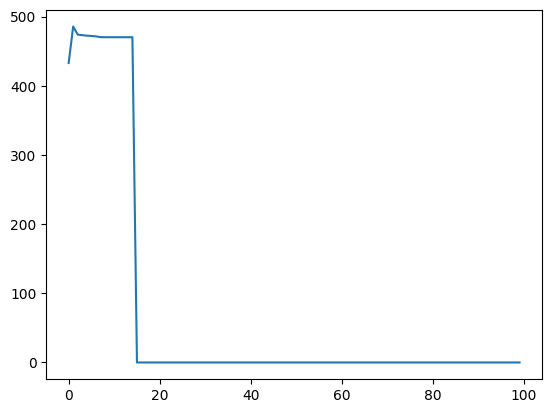

In [ ]:
plt.plot(log_verosim)
plt.show()

In [ ]:
create_HMM(initial_state_matrix,transition_matrix,[prior_1,prior_2])
predicted_results  = hmm.posterior_mode(test["Change"].astype(np.float32)).numpy()
print("F1-score:",compute_Fbeta_score(test["NBER"],predicted_results))
print("F2-score:",compute_Fbeta_score(test["NBER"],predicted_results,beta=2))

F1-score: 0.5671641791044777
F2-score: 0.48469387755102045


### Usando la propia probabilidad de la clase hmm

Podemos usar el método `HiddenMarkovModel.marginal_probs` que nos devuelve la probabilidad de que el HMM esté en un estado en un tiempo t. Nos devuelve una matriz.

In [ ]:
gamma[0,0]*transition_matrix[0,0]*prior_1.prob(observations.iat[i+1])*gamma[]

<tf.Tensor: shape=(), dtype=float64, numpy=0.16733990775064325>

In [ ]:
posterior_dists = hmm.posterior_marginals(train["Change"].astype(np.float32))
posterior_probs = posterior_dists.probs_parameter().numpy()
print(posterior_probs)

[[8.61356020e-01 1.38643906e-01]
 [8.59324634e-01 1.40675291e-01]
 [9.00291681e-01 9.97082964e-02]
 [9.76271629e-01 2.37283204e-02]
 [9.87045646e-01 1.29543776e-02]
 [9.74682927e-01 2.53170356e-02]
 [8.90007794e-01 1.09992251e-01]
 [6.38461947e-01 3.61537963e-01]
 [2.21250758e-01 7.78749168e-01]
 [3.27076972e-01 6.72923088e-01]
 [4.74364817e-01 5.25635123e-01]
 [3.86777878e-01 6.13222003e-01]
 [5.00068665e-01 4.99931335e-01]
 [7.27655053e-01 2.72344977e-01]
 [8.00852656e-01 1.99147329e-01]
 [9.60255265e-01 3.97446901e-02]
 [9.88282621e-01 1.17172571e-02]
 [9.93431628e-01 6.56843046e-03]
 [9.92458880e-01 7.54106790e-03]
 [9.83626902e-01 1.63730234e-02]
 [9.88055885e-01 1.19441599e-02]
 [9.78925943e-01 2.10741367e-02]
 [9.79770720e-01 2.02292725e-02]
 [9.64102328e-01 3.58975865e-02]
 [9.51954126e-01 4.80459668e-02]
 [8.23252857e-01 1.76747069e-01]
 [3.37858617e-01 6.62141383e-01]
 [1.17638640e-01 8.82361352e-01]
 [3.25386584e-01 6.74613476e-01]
 [7.02408850e-01 2.97591120e-01]
 [9.346118